In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df_fullco2 = pd.read_csv('data/co2.csv')
df_climate = pd.read_csv('data/climate.csv')

In [6]:
df_climate.isna().sum()


country_code       0
year               0
month              0
R1               126
temp_mean          0
temp_max        1071
temp_min        1081
dtype: int64

In [ ]:
df_fullco2.isna().sum()

country_code      0
year              0
value             0
co2_per_capita    0
dtype: int64

In [ ]:
df_fullco2['year'].min(), df_fullco2['year'].max()

(np.int64(1970), np.int64(2019))

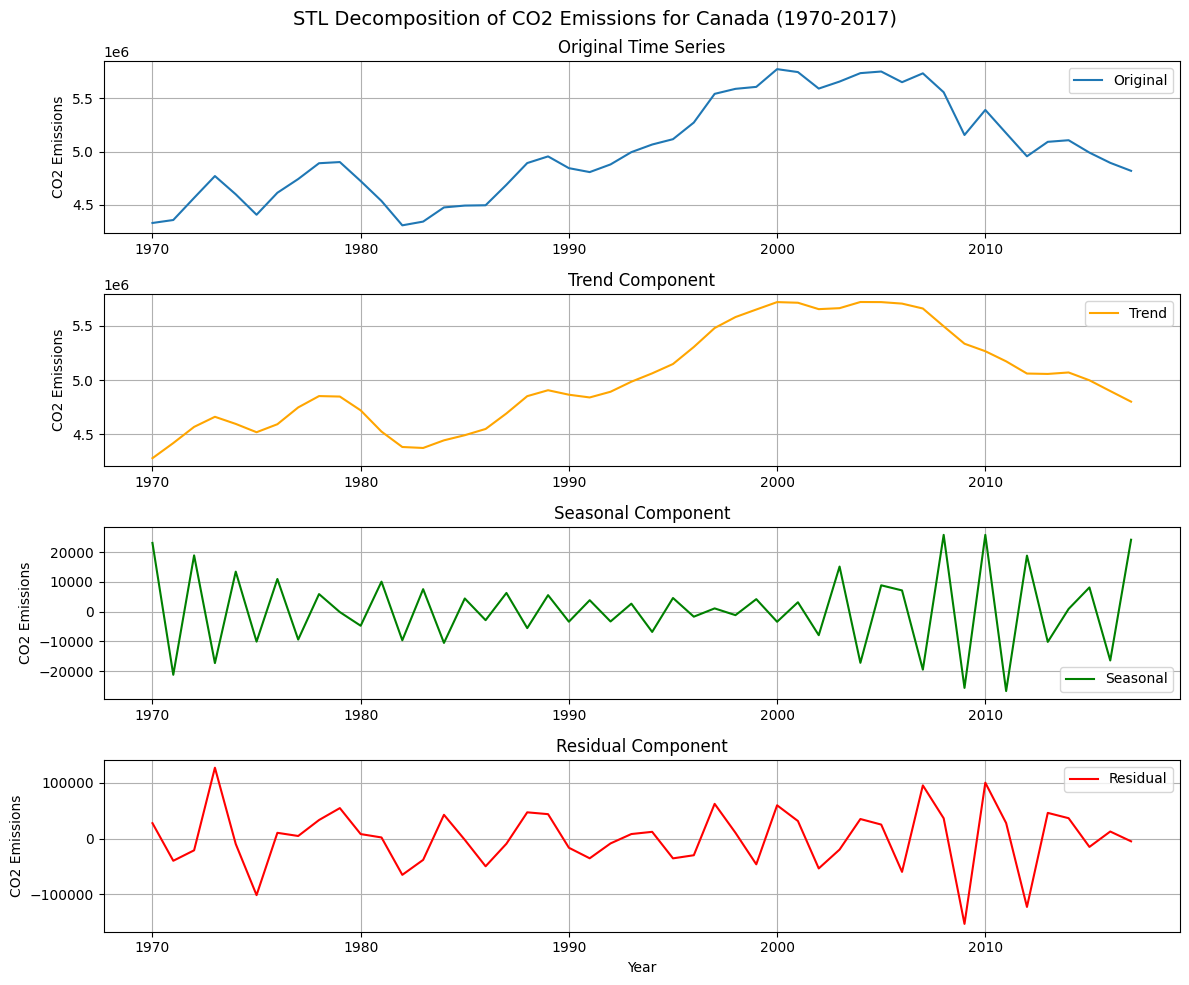

Summary Statistics:
Original series mean: 5012611.86
Trend component mean: 5010753.32
Seasonal component mean: 519.52
Residual component mean: 1339.02
Residual component std: 52967.48


In [ ]:
# Filter data for Canada (CAN) from 1970 to 2017
df_ca = df_fullco2[(df_fullco2['country_code'] == 'USA') & 
                    (df_fullco2['year'] >= 1970) & 
                    (df_fullco2['year'] <= 2017)].copy()

# Sort by year to ensure proper time series order
df_ca = df_ca.sort_values('year')

# Create time series from the 'value' column (CO2 emissions)
ts_ca = df_ca['value'].values

# Perform STL decomposition
# Note: Since data is yearly (one observation per year), there's no intra-year seasonality
# STL requires period >= 2, so we use period=2 (minimum required)
# This will extract trend and residual components, with minimal seasonal component
stl = STL(ts_ca, seasonal=7, period=2)
result = stl.fit()

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
fig.suptitle('STL Decomposition of CO2 Emissions for Canada (1970-2017)', fontsize=14)

axes[0].plot(df_ca['year'], result.observed, label='Original')
axes[0].set_ylabel('CO2 Emissions')
axes[0].set_title('Original Time Series')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(df_ca['year'], result.trend, label='Trend', color='orange')
axes[1].set_ylabel('CO2 Emissions')
axes[1].set_title('Trend Component')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(df_ca['year'], result.seasonal, label='Seasonal', color='green')
axes[2].set_ylabel('CO2 Emissions')
axes[2].set_title('Seasonal Component')
axes[2].grid(True)
axes[2].legend()

axes[3].plot(df_ca['year'], result.resid, label='Residual', color='red')
axes[3].set_ylabel('CO2 Emissions')
axes[3].set_xlabel('Year')
axes[3].set_title('Residual Component')
axes[3].grid(True)
axes[3].legend()

plt.tight_layout()
plt.show()

# Display summary statistics
print("Summary Statistics:")
print(f"Original series mean: {result.observed.mean():.2f}")
print(f"Trend component mean: {result.trend.mean():.2f}")
print(f"Seasonal component mean: {result.seasonal.mean():.2f}")
print(f"Residual component mean: {result.resid.mean():.2f}")
print(f"Residual component std: {result.resid.std():.2f}")


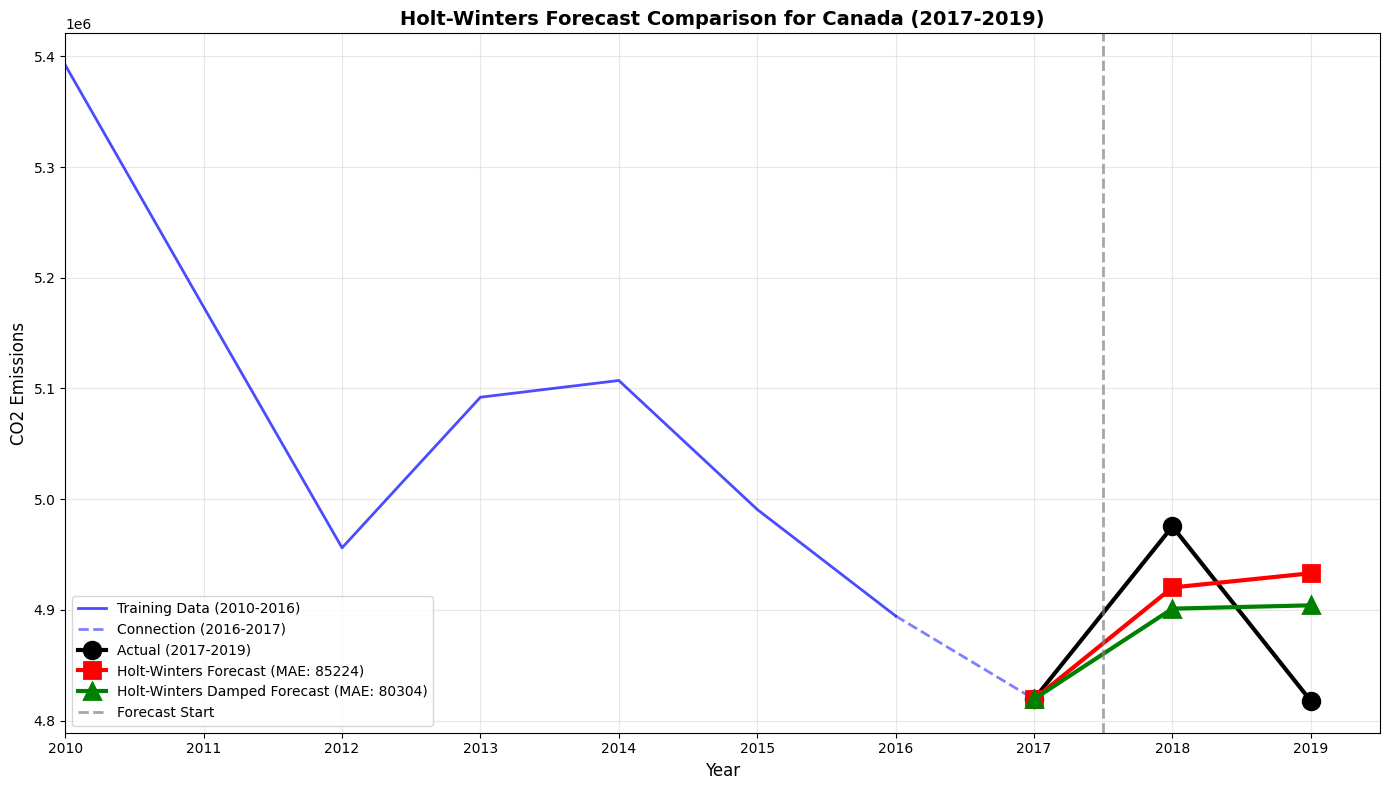


FORECAST ACCURACY METRICS

Holt-Winters (Regular):
  MAE:  85223.80
  RMSE: 90392.86
  MAPE: 1.75%

Holt-Winters (Damped):
  MAE:  80304.07
  RMSE: 80533.70
  MAPE: 1.64%



In [ ]:
# Get actual values for 2017-2019 for comparison
df_ca_actual = df_fullco2[(df_fullco2['country_code'] == 'USA') & 
                           (df_fullco2['year'] >= 2017) & 
                           (df_fullco2['year'] <= 2019)].copy()
df_ca_actual = df_ca_actual.sort_values('year')
actual_values = df_ca_actual['value'].values
actual_years = df_ca_actual['year'].values

# Prepare training data up to 2016 (to forecast 2017-2019)
train_mask = df_ca['year'] <= 2016
train_data = df_ca[train_mask]['value'].values
train_years = df_ca[train_mask]['year'].values

# Fit Holt-Winters model (regular - additive trend)
hw_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
hw_fitted = hw_model.fit()

# Fit Holt-Winters model with damped trend
hw_damped_model = ExponentialSmoothing(train_data, trend='add', seasonal=None, damped_trend=True)
hw_damped_fitted = hw_damped_model.fit()

# Forecast for 2017-2019 (3 years ahead)
forecast_steps = 3
hw_forecast = hw_fitted.forecast(steps=forecast_steps)
hw_damped_forecast = hw_damped_fitted.forecast(steps=forecast_steps)

# Create forecast years
forecast_years = np.array([2017, 2018, 2019])

# Get actual values for 2018-2019 only (for metrics calculation, excluding 2017)
actual_values_2018_2019 = actual_values[actual_years >= 2018]
hw_forecast_2018_2019 = hw_forecast[1:]  # Skip 2017, keep 2018-2019
hw_damped_forecast_2018_2019 = hw_damped_forecast[1:]  # Skip 2017, keep 2018-2019

# Calculate metrics (only for 2018-2019)
mae_hw = mean_absolute_error(actual_values_2018_2019, hw_forecast_2018_2019)
mae_damped = mean_absolute_error(actual_values_2018_2019, hw_damped_forecast_2018_2019)
rmse_hw = np.sqrt(mean_squared_error(actual_values_2018_2019, hw_forecast_2018_2019))
rmse_damped = np.sqrt(mean_squared_error(actual_values_2018_2019, hw_damped_forecast_2018_2019))
mape_hw = mean_absolute_percentage_error(actual_values_2018_2019, hw_forecast_2018_2019)
mape_damped = mean_absolute_percentage_error(actual_values_2018_2019, hw_damped_forecast_2018_2019)

# Filter training data to show recent years for context (2010-2016, excluding 2017)
recent_mask = (train_years >= 2010) & (train_years < 2017)
recent_years = train_years[recent_mask]
recent_data = train_data[recent_mask]

# Plot the comparison
fig, ax = plt.subplots(figsize=(14, 8))

# Plot recent training data for context (2010-2016)
ax.plot(recent_years, recent_data, label='Training Data (2010-2016)', color='blue', linewidth=2, alpha=0.7)

# Get 2016 value (last training point) and 2017 value (first actual point) to connect them
year_2016_idx = np.where(recent_years == 2016)[0]
year_2017_idx = np.where(actual_years == 2017)[0]

# Draw connection line from 2016 to 2017
if len(year_2016_idx) > 0 and len(year_2017_idx) > 0:
    x_connection = [recent_years[year_2016_idx[0]], actual_years[year_2017_idx[0]]]
    y_connection = [recent_data[year_2016_idx[0]], actual_values[year_2017_idx[0]]]
    ax.plot(x_connection, y_connection, '--', color='blue', linewidth=2, alpha=0.5, label='Connection (2016-2017)')

# Plot actual values for 2017-2019
ax.plot(actual_years, actual_values, 'o-', label='Actual (2017-2019)', 
        color='black', markersize=12, linewidth=3, markerfacecolor='black', markeredgewidth=2)

# Get actual 2017 value to start forecasts from
actual_2017_value = actual_values[actual_years == 2017][0] if len(actual_values[actual_years == 2017]) > 0 else None

# Create forecast lines starting from actual 2017 value
if actual_2017_value is not None:
    # Start from actual 2017, then use forecasts for 2018-2019
    hw_forecast_with_start = np.concatenate([[actual_2017_value], hw_forecast[1:]])
    hw_damped_forecast_with_start = np.concatenate([[actual_2017_value], hw_damped_forecast[1:]])
    forecast_years_with_start = np.concatenate([[2017], forecast_years[1:]])
    
    # Plot forecasts starting from actual 2017 value
    ax.plot(forecast_years_with_start, hw_forecast_with_start, 's-', label=f'Holt-Winters Forecast (MAE: {mae_hw:.0f})', 
            color='red', markersize=12, linewidth=3, markerfacecolor='red', markeredgewidth=2)
    ax.plot(forecast_years_with_start, hw_damped_forecast_with_start, '^-', label=f'Holt-Winters Damped Forecast (MAE: {mae_damped:.0f})', 
            color='green', markersize=12, linewidth=3, markerfacecolor='green', markeredgewidth=2)
else:
    # Fallback to original if 2017 value not found
    ax.plot(forecast_years, hw_forecast, 's-', label=f'Holt-Winters Forecast (MAE: {mae_hw:.0f})', 
            color='red', markersize=12, linewidth=3, markerfacecolor='red', markeredgewidth=2)
    ax.plot(forecast_years, hw_damped_forecast, '^-', label=f'Holt-Winters Damped Forecast (MAE: {mae_damped:.0f})', 
            color='green', markersize=12, linewidth=3, markerfacecolor='green', markeredgewidth=2)

# Add vertical line to separate training and forecast periods
ax.axvline(x=2017.5, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Forecast Start')

# Focus the x-axis on 2010-2019, with emphasis on 2018-2019
ax.set_xlim(2010, 2019.5)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('CO2 Emissions', fontsize=12)
ax.set_title('Holt-Winters Forecast Comparison for Canada (2017-2019)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Add minor ticks for better readability
ax.set_xticks(range(2010, 2020))
ax.tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

# Print metrics
print("\n" + "="*60)
print("FORECAST ACCURACY METRICS")
print("="*60)
print(f"\nHolt-Winters (Regular):")
print(f"  MAE:  {mae_hw:.2f}")
print(f"  RMSE: {rmse_hw:.2f}")
print(f"  MAPE: {mape_hw:.2%}")
print(f"\nHolt-Winters (Damped):")
print(f"  MAE:  {mae_damped:.2f}")
print(f"  RMSE: {rmse_damped:.2f}")
print(f"  MAPE: {mape_damped:.2%}")
print("\n" + "="*60)


In [ ]:
# Test Holt-Winters models on 10 countries
# Select 10 diverse countries for testing
test_countries = ['USA', 'CHN', 'IND', 'RUS', 'JPN', 'DEU', 'GBR', 'FRA', 'CAN', 'BRA']

results = []

print("Testing Holt-Winters models on 10 countries...")
print("="*70)

for country in test_countries:
    try:
        # Get data for the country
        df_country = df_fullco2[(df_fullco2['country_code'] == country) & 
                                (df_fullco2['year'] >= 1970) & 
                                (df_fullco2['year'] <= 2019)].copy()
        df_country = df_country.sort_values('year')
        
        if len(df_country) < 20:  # Need sufficient data
            print(f"{country}: Insufficient data")
            continue
        
        # Prepare training data up to 2016
        train_mask = df_country['year'] <= 2016
        train_data = df_country[train_mask]['value'].values
        
        if len(train_data) < 10:  # Need sufficient training data
            print(f"{country}: Insufficient training data")
            continue
        
        # Get actual values for 2018-2019
        actual_mask = (df_country['year'] >= 2018) & (df_country['year'] <= 2019)
        actual_values = df_country[actual_mask]['value'].values
        actual_years = df_country[actual_mask]['year'].values
        
        if len(actual_values) < 2:  # Need both 2018 and 2019
            print(f"{country}: Missing actual values for 2018-2019")
            continue
        
        # Fit Holt-Winters model (regular)
        try:
            hw_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
            hw_fitted = hw_model.fit()
            hw_forecast = hw_fitted.forecast(steps=3)  # Forecast 2017-2019
            hw_forecast_2018_2019 = hw_forecast[1:]  # Get 2018-2019 only
            mape_hw = mean_absolute_percentage_error(actual_values, hw_forecast_2018_2019)
        except:
            mape_hw = np.nan
        
        # Fit Holt-Winters model with damped trend
        try:
            hw_damped_model = ExponentialSmoothing(train_data, trend='add', seasonal=None, damped_trend=True)
            hw_damped_fitted = hw_damped_model.fit()
            hw_damped_forecast = hw_damped_fitted.forecast(steps=3)  # Forecast 2017-2019
            hw_damped_forecast_2018_2019 = hw_damped_forecast[1:]  # Get 2018-2019 only
            mape_damped = mean_absolute_percentage_error(actual_values, hw_damped_forecast_2018_2019)
        except:
            mape_damped = np.nan
        
        # Store results
        results.append({
            'country': country,
            'mape_hw': mape_hw,
            'mape_damped': mape_damped
        })
        
        print(f"{country:4s} | HW MAPE: {mape_hw:8.4%} | HW Damped MAPE: {mape_damped:8.4%}")
        
    except Exception as e:
        print(f"{country}: Error - {str(e)}")
        continue

print("="*70)

# Calculate mean MAPE across all countries
if len(results) > 0:
    mean_mape_hw = np.nanmean([r['mape_hw'] for r in results])
    mean_mape_damped = np.nanmean([r['mape_damped'] for r in results])
    
    print(f"\n{'='*70}")
    print(f"MEAN MAPE ACROSS {len(results)} COUNTRIES")
    print(f"{'='*70}")
    print(f"Holt-Winters (Regular) Mean MAPE:     {mean_mape_hw:.4%}")
    print(f"Holt-Winters (Damped) Mean MAPE:      {mean_mape_damped:.4%}")
    print(f"{'='*70}")
else:
    print("\nNo valid results obtained.")


Testing Holt-Winters models on 10 countries...
USA  | HW MAPE:  1.7509% | HW Damped MAPE:  1.6424%
CHN  | HW MAPE:  7.0936% | HW Damped MAPE:  7.2814%
IND  | HW MAPE:  5.0769% | HW Damped MAPE:  5.5218%
RUS  | HW MAPE:  9.0283% | HW Damped MAPE:  7.0251%
JPN  | HW MAPE:  8.1146% | HW Damped MAPE:  7.0330%
DEU  | HW MAPE:  3.1824% | HW Damped MAPE:  6.1018%
GBR  | HW MAPE:  4.1427% | HW Damped MAPE:  4.7226%
FRA  | HW MAPE:  0.5993% | HW Damped MAPE:  1.9493%
CAN  | HW MAPE:  2.0229% | HW Damped MAPE:  3.0246%
BRA  | HW MAPE:  7.4061% | HW Damped MAPE:  6.8368%

MEAN MAPE ACROSS 10 COUNTRIES
Holt-Winters (Regular) Mean MAPE:     4.8418%
Holt-Winters (Damped) Mean MAPE:      5.1139%
